# 線形回帰

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


教育用標準データセットにはe-Stat（政府統計の総合窓口）から取得された市区町村別の統計データが表形式で含まれています。

[教育用標準データセット](https://www.nstac.go.jp/SSDSE/)

以下では、データの欠損値や外れ値の処理を行った上で、各市区町村の総人口数から医師数を回帰する回帰モデルを学習してみます。

In [ ]:
# matplotlib日本語化用モジュールをインストール
!pip install japanize-matplotlib

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import japanize_matplotlib 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2020A/master/ex8/SSDSE-2020A.csv

In [39]:
# データの読みこみ
df = pd.read_csv('SSDSE-2020A.csv', skiprows=[0,1], encoding='utf_8')
df = df[['市区町村','総人口','医師数']]

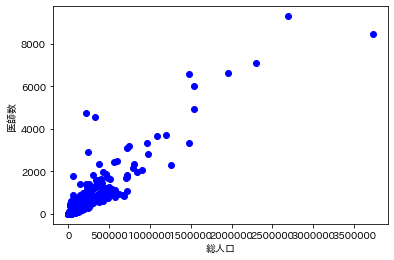

In [40]:
# 散布図
plt.xlabel('総人口') 
plt.ylabel('医師数') 
plt.scatter(df['総人口'], df['医師数'], color='blue') 
plt.show()

In [41]:
# 欠損値の処理
# 総人口が0の市町村は除く
df.loc[df['総人口'] == 0, '総人口'] = None 
df = df.dropna()

In [42]:
# 外れ値の処理
for c in ['総人口','医師数']: 
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75) 
    iqr = q3 - q1 
    lower = q1 - iqr * 1.5 
    upper = q3 + iqr * 1.5 
    df.loc[(df[c] < lower) | (df[c] > upper), c] = None 
df = df.dropna()

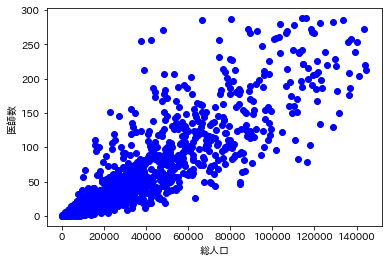

In [43]:
# 散布図
plt.xlabel('総人口') 
plt.ylabel('医師数') 
plt.scatter(df['総人口'], df['医師数'], color='blue') 
plt.show()

`scikit-learn`では、以下の手順でデータからモデルの学習を行います。
- 使用するモデルのクラスの選択
- モデルのハイパーパラメータの選択とインスタンス化
- データの準備
    - 教師あり学習では、特徴量データとラベルデータを準備
    - 教師あり学習では、特徴量・ラベルデータをモデル学習用の学習データとモデル評価用のテストデータに分ける
- モデルをデータに適合（`fit()`メソッド）
- モデルの評価
    - 教師あり学習では、`predict()`メソッドを用いてテストデータの特徴量データからラベルデータを予測しその精度を評価を行う
    
以下では、回帰を行うモデルの一つである**線形回帰**（**`LinearRegression`**）クラスをインポートしています。`mean_squared_error()`は平均二乗誤差によりモデルの予測精度を評価するための関数です。

線形回帰クラスのインスタンスの`fit()`メソッドによりモデルをデータに適合させ、`predict()`メソッドを用いて入力`X`から出力`y_pred`を予測し、`mean_squared_error()`関数で実際の値（`y`）と比較して予測精度の評価を行なっています。

In [44]:
# 線形回帰
X=df[['総人口']].values
y=df['医師数'].values
model=LinearRegression()
model.fit(X, y)
y_pred = model.predict(X) 
loss = mean_squared_error(y, y_pred)
print('誤差:', '{:.2f}'.format(loss))

誤差: 871.19


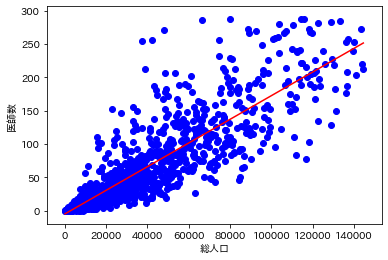

In [45]:
# 回帰直線
X_point=np.arange(np.min(X), np.max(X), 100).reshape(-1,1)
y_point=model.predict(X_point)
plt.plot(X_point, y_point, color='red')
plt.xlabel('総人口')
plt.ylabel('医師数')
plt.scatter(X, y, color='blue') 
plt.show()

データセットを訓練データ（`X_train`, `y_train`）とテストデータ（`X_test`, `y_test`)に分割し、線形回帰クラスのインスタンスの`fit()`メソッドによりモデルを訓練データに適合させています。そして、`predict()`メソッドを用いてテストデータの入力から出力の値を予測し、`mean_squared_error()`関数で実際の値と比較して予測精度の評価を行なっています。

In [46]:
# 訓練データとテストデータ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0) 
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train) 
y_pred_test = model.predict(X_test) 
train_loss = mean_squared_error(y_train, y_pred_train)
test_loss = mean_squared_error(y_test, y_pred_test) 
print('訓練データ誤差:', '{:.2f}'.format(train_loss))
print('テストデータ誤差:', '{:.2f}'.format(test_loss))

訓練データ誤差: 849.13
テストデータ誤差: 926.57


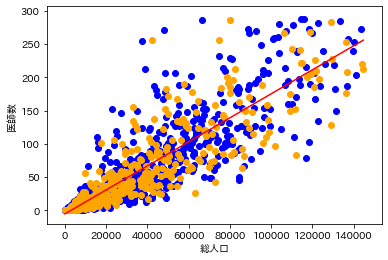

In [47]:
X_point=np.arange(np.min(X), np.max(X), 100).reshape(-1,1)
y_point=model.predict(X_point)
plt.plot(X_point, y_point, color='red')
plt.xlabel('総人口')
plt.ylabel('医師数')
plt.scatter(X_train, y_train, color='blue') # 訓練データ
plt.scatter(X_test, y_test, color='orange') # テストデータ
plt.show()

`scikit-learn`モジュールの`PolynomialFeatures`クラスを使うと入力の特徴量から多項や交差項の特徴量を生成することができます。多項や交差項の特徴量を導入にすることによりモデルが複雑になり、訓練データへのより柔軟な適合が可能になります。

例えば、多項式の次数としてパラメータ`degree`に2を指定すると、1変数の入力$x$に対して、1（バイアス項), $x$, $x^2$、の3つの特徴量を生成します。2変数入力$x_1, x_2$の場合は、1, $x_1$, $x_2$, $x_1^2$, $x_1x_2$, $x_2^2$、の特徴量が生成されます。バイアス項を生成しない場合はパラメータ`include_bias`に`False`を指定します。

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)

In [48]:
# 多項式回帰
n=10
poly=PolynomialFeatures(degree=n, include_bias=False)
poly_X_train=poly.fit_transform(X_train) 
poly_X_test=poly.fit_transform(X_test) 
model=LinearRegression(normalize=True)
model.fit(poly_X_train, y_train)
y_pred_train=model.predict(poly_X_train) 
y_pred_test=model.predict(poly_X_test) 
train_loss = mean_squared_error(y_train, y_pred_train)
test_loss = mean_squared_error(y_test, y_pred_test) 
print('訓練データ誤差:', '{:.2f}'.format(train_loss))
print('テストデータ誤差:', '{:.2f}'.format(test_loss))

訓練データ誤差: 826.69
テストデータ誤差: 959.84


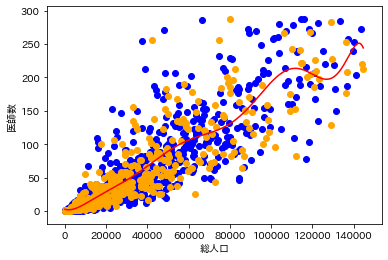

In [49]:
X_point=np.arange(np.min(X), np.max(X), 100).reshape(-1,1)
y_point=model.predict(poly.fit_transform(X_point))
plt.plot(X_point, y_point, color='red')
plt.xlabel('総人口')
plt.ylabel('医師数')
plt.scatter(X_train, y_train, color='blue') # 訓練データ
plt.scatter(X_test, y_test, color='orange') # テストデータ
plt.show()